In [1]:
import pandas as pd
import numpy as np

from typing import Literal

In [2]:
# read dataset
df = pd.read_csv('housing.csv')

In [3]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


<AxesSubplot:>

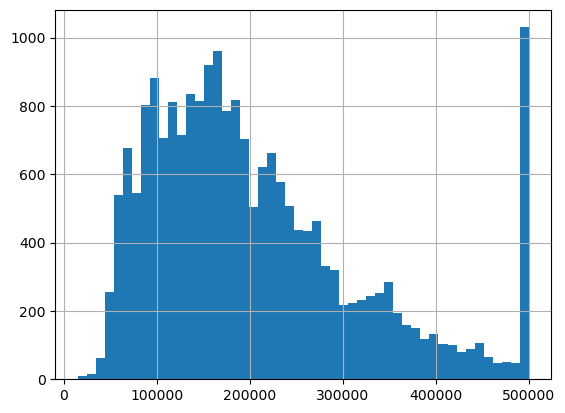

In [4]:
df['median_house_value'].hist(bins=50)

In [5]:
features = [
    'latitude', 'longitude', 'housing_median_age', 'total_rooms',
    'total_bedrooms', 'population', 'households', 'median_income',
]
target = ['median_house_value']
df = df[features + target]

---

### Question 1

Find a feature with missing values. How many missing values does it have?

In [6]:
df.isna().sum()

latitude                0
longitude               0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

### Question 2

What's the median (50% percentile) for variable 'population'?

In [7]:
df['population'].median()

1166.0

### Split the data

In [8]:
# Split your data in train/val/test sets, with 60%/20%/20% distribution
def train_val_test_split(df, seed):
    df = df.copy()

    n = len(df)
    idx = np.arange(n)
    np.random.seed(seed)
    np.random.shuffle(idx)
    df_shuffled = df.iloc[idx].reset_index(drop=True)

    n_train = int(n * 0.6)
    n_val = int(n * 0.2)
    n_test = int(n - n_train - n_val)

    df_train = df_shuffled[:n_train]
    df_val = df_shuffled[n_train:(n_train + n_val)]
    df_test = df_shuffled[(n_train + n_val):]

    y_train = np.log1p(df_train['median_house_value'])
    y_val = np.log1p(df_val['median_house_value'])
    y_test = np.log1p(df_test['median_house_value'])

    del df_train['median_house_value']
    del df_val['median_house_value']
    del df_test['median_house_value']

    return df_train, df_val, df_test, y_train, y_val, y_test

In [9]:
df_train, df_val, df_test, y_train, y_val, y_test = train_val_test_split(df=df, seed=42)

### Question 3

We need to deal with missing values for the column from Q1.

We have two options: fill it with 0 or with the mean of this variable.
Try both options. (For computing the mean, use the training only!)

For each, train a linear regression model without regularization using the code from the lessons.

Use the validation dataset to evaluate the models and compare the RMSE of each option.
Round the RMSE scores to 2 decimal digits using round(score, 2)
Which option gives better RMSE?

In [10]:
def train_linear_regression(X, y):
    # add intercept
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    # train model
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)

    return w[0], w[1:]


def rmse(y, y_pred):
    error = y_pred - y
    mse = (error**2).mean()
    return np.sqrt(mse)

In [11]:
avg_tb = df_train['total_bedrooms'].mean() # constant
print(avg_tb)

def prepare_X(df, fill_strategy: Literal['zero', 'mean']):
    df_num = df[features]
    if fill_strategy == 'zero':
        df_num['total_bedrooms'] = df_num['total_bedrooms'].fillna(0)
    elif fill_strategy == 'mean':
        df_num['total_bedrooms'] = df_num['total_bedrooms'].fillna(avg_tb)
    X = df_num.values

    return X

533.4803317730147


In [12]:
# option 1
X_train = prepare_X(df_train, fill_strategy='zero')
w0, w = train_linear_regression(X_train, y_train)

# evaluate the regression
X_val = prepare_X(df_val, fill_strategy='zero')
y_pred = w0 + X_val.dot(w)
print(round(rmse(y_val, y_pred), 2))

0.33


In [13]:
# option 2
X_train = prepare_X(df_train, fill_strategy='mean')
w0, w = train_linear_regression(X_train, y_train)

# evaluate the regression
X_val = prepare_X(df_val, fill_strategy='mean')
y_pred = w0 + X_val.dot(w)
print(round(rmse(y_val, y_pred), 2))

0.33


In [14]:
# check if matrices are the same
np.array_equal(prepare_X(df_train, fill_strategy='mean'),
               prepare_X(df_train, fill_strategy='zero'))


False

### Question 4

Now let's train a regularized linear regression.
For this question, fill the NAs with 0.

Try different values of r from this list: [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10].

Use RMSE to evaluate the model on the validation dataset.
Round the RMSE scores to 2 decimal digits.

Which r gives the best RMSE? If there are multiple options, select the smallest r.

In [15]:
def train_linear_regression(X, y, r=0):
    # add intercept
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    # train model
    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])  # apply regularization
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)

    return w[0], w[1:]

In [16]:
X_train = prepare_X(df_train, fill_strategy='zero')
X_val = prepare_X(df_val, fill_strategy='zero')

for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w0, w = train_linear_regression(X_train, y_train, r=r)
    y_pred = w0 + X_val.dot(w)
    rmse_value = round(rmse(y_val, y_pred), 2)
    print(f'r = {r}, rmse = {rmse_value}')

r = 0, rmse = 0.33
r = 1e-06, rmse = 0.33
r = 0.0001, rmse = 0.33
r = 0.001, rmse = 0.33
r = 0.01, rmse = 0.33
r = 0.1, rmse = 0.33
r = 1, rmse = 0.33
r = 5, rmse = 0.34
r = 10, rmse = 0.34


### Question 5

We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
Try different seed values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9].

For each seed, do the train/validation/test split with 60%/20%/20% distribution.
Fill the missing values with 0 and train a model without regularization.

For each seed, evaluate the model on the validation dataset and collect the RMSE scores.

What's the standard deviation of all the scores? To compute the standard deviation, use np.std.
Round the result to 3 decimal digits (round(std, 3))


In [17]:
rmse_list = []

for seed in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    df_train, df_val, _, y_train, y_val, _ = train_val_test_split(df=df,
                                                                  seed=seed)

    X_train = prepare_X(df_train, fill_strategy='zero')
    X_val = prepare_X(df_val, fill_strategy='zero')

    w0, w = train_linear_regression(X_train, y_train, r=0)
    y_pred = w0 + X_val.dot(w)
    rmse_list.append(rmse(y_val, y_pred))

print(round(np.std(rmse_list), 3))

0.004


### Question 6

Split the dataset like previously, use seed 9.
Combine train and validation datasets.
Fill the missing values with 0 and train a model with r=0.001.

What's the RMSE on the test dataset?

In [18]:
df_train, df_val, df_test, y_train, y_val, y_test = train_val_test_split(df=df,
seed=9)

df_train = pd.concat([df_train, df_val])
y_train = pd.concat([y_train, y_val])
X_train = prepare_X(df_train, fill_strategy='zero')
w0, w = train_linear_regression(X_train, y_train, r=0.001)

X_test = prepare_X(df_test, fill_strategy='zero')
y_pred = w0 + X_test.dot(w)
print(rmse(y_test, y_pred))

0.34531689143895156
